# CSCI 4140 Assignment Three

#### Introduction
Portfolio optimization is a very important problem in finance. One of the main reasons why
financial institutions are interested in quantum computers. The statement of this problem is quite
simple, but the solution in general can be quite complicated. You have a fixed amount of money
and you want to invest it in a number of assets (stocks, bonds, mutual funds, etc.) to get the
maximum return with the minimum risk.
Mathematically we state our simple version of the problem in the following way:
$$^{min}_{x}(qx^{T}Σ𝑥 − 𝜇^{T}x)$$

Subject to:
$$∑_{i}𝑥_{𝑖} = 𝐵$$


Where Σ is the covariance matrix for the assets, 𝜇 is the expected return on the assets, q is the
risk appetite of the investor (use the value q=0.5) and B is the total budget.

To make things simple we will assume that all assets have the same price and that we can only
buy one unit of them. In this case the 𝑥𝑖 become binary variables. We will have 4 assets and our
total budget is 2. Clearly this is an optimization problem that you will need to solve.
#### Data
Where are we going to get the data from? It turns out that Qiskit has a procedure for doing this
and it will compute the covariance matrix and the expected return for you.
Here are some imports to get you started:

In [3]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE,QAOA, NumPyMinimumEigensolver
import numpy as np
import matplotlib.pyplot as plt
import datetime
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.converters import QuadraticProgramToQubo

We use the random data provider to generate some random stock information to be used in this
assignment:

In [78]:
num_assets = 4

#Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider(tickers=stocks,
                         start=datetime.datetime(2016,1,1),
                         end=datetime.datetime(2016,1,30))
data.run()
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

This provides the covariance matrix and average returns that you need to get started.
#### Procedure
Start by constructing a QuadraticProblem for the optimization and data. Then you can basically
follow the steps that we have used in the lecture. First, use a classical optimization solver to
determine the correct answer. This will be your starting point.

From there you can choose any of the quantum optimization techniques that we described in
class. I found that Grover worked the best, but it is more work. You will need to experiment a
bit with the parameters. Remember, for many of these problems the first attempt doesn’t always
work out. You may need to run it several times and experiment with the parameters.
#### Assignment Report
For the assignment report show how you converted the optimization problem into a quantum
program and the results you obtained. Submit this as a PDF file using Canvas.
#### Note
When setting up the quadratic problem you can specify that the variables are binary and give
them a name using
```python
        model.binary_var(name=’variable name’)
```
You would do this for each of the variables in the model

### Steps

In [55]:
import qiskit.tools.jupyter

from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
import datetime

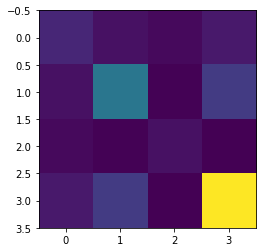

In [9]:
plt.imshow(sigma, interpolation='nearest')
plt.show()

Start by constructing a QuadraticProblem for the optimization and data.

In [2]:
# Import a model from DOcplex
from docplex.mp.model import Model

# Name the model
ndl = Model('MinCut')

# Add a binary variable to the model for each node in the graph
x = ndl.binary_var_list('x{}'.format(i) for i in range(4))

# Define the objective function - more of a pseudo algorithm
objective = q * model.sum([sigma[i,j] * x[i] * x[j] for i range(4) for j in range(4)]) \
            - model.sum([mu[i] * x[i] for i in range(4)])

# Add an equality constraint
B = 2
ndl.add_constraint(ndl.sum(x[i] for i in range(4)) == B)

# And let's maximize it!
ndl.minimize(objective)

# Let's print the model
ndl.prettyprint()

SyntaxError: invalid syntax (<ipython-input-2-e9a9d68f33c9>, line 11)

Then you can basically follow the steps that we have used in the lecture. First, use a classical optimization solver to determine the correct answer. This will be your starting point. From there you can choose any of the quantum optimization techniques that we described in class. I found that Grover worked the best, but it is more work. You will need to experiment a bit with the parameters. 

Remember, for many of these problems the first attempt doesn’t always work out. You may need to run it several times and experiment with the parameters.

In [85]:
qp = QuadraticProgram()

# Put the model inside it
qp.from_docplex(ndl)

print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MinCut

Minimize
 obj:
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1

Binaries
 x0 x1 x2 x3
End



In [11]:
q = 0.5

budget = num_assets // 2
penalty = num_assets

qubitOp, offset = portfolio.get_operator(mu, sigma, q, budget, penalty)
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x



def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, mu, sigma, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, mu, sigma, q, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [14]:
solver = NumPyMinimumEigensolver(qubitOp)
result = solver.run()
print(result)
print_result(result)

{'eigenvalue': (-4.0088051883937315+0j), 'eigenstate': VectorStateFn(Statevector([0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2)), coeff=1.0, is_measurement=False)}
Optimal: selection [1 1 0 0], value 0.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 1 0 0]	0.0000		1.0000
 [1 1 1 1]	16.0179		0.0000
 [0 1 1 1]	4.0159		0.0000
 [1 0 1 1]	4.0193		0.0000
 [0 0 1 1]	0.0174		0.0000
 [1 1 0 1]	4.0150		0.0000
 [0 1 0 1]	0.0130		0.0000
 [1 0 0 1]	0.0164		0.0000
 [0 0 0 1]	4.0145		0.0000
 [1 1 1 0]	4.0030		0.0000
 [0 1 1 0]	0.0010		0.0000
 [1 0 1 0]	0.0048		0.0000
 [0 0 1 0]	4.0029		0.0000
 [0 1 0 0]	3.9981		0.0000
 [1 0 0 0]	4.0018		0.0000
 [0 0 0 0]	16.0000		0.0000


In [15]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print_result(result)

Optimal: selection [1. 0. 1. 0.], value 0.0048

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	0.0048		0.9013
 [0 1 1 0]	0.0010		0.0769
 [1 1 0 0]	0.0000		0.0138
 [0 0 1 1]	0.0174		0.0067
 [1 0 0 1]	0.0164		0.0009
 [0 1 0 0]	3.9981		0.0003
 [1 0 0 0]	4.0018		0.0000
 [0 0 0 1]	4.0145		0.0000
 [1 1 0 1]	4.0150		0.0000
 [0 1 1 1]	4.0159		0.0000
 [0 0 0 0]	16.0000		0.0000
 [1 1 1 0]	4.0030		0.0000
 [0 0 1 0]	4.0029		0.0000
 [0 1 0 1]	0.0130		0.0000
 [1 0 1 1]	4.0193		0.0000
 [1 1 1 1]	16.0179		0.0000


In [16]:
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

print_result(result)

Optimal: selection [1. 1. 0. 0.], value 0.0000

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 1 0 0]	0.0000		0.1668
 [0 1 1 0]	0.0010		0.1668
 [1 0 1 0]	0.0048		0.1667
 [0 1 0 1]	0.0130		0.1666
 [1 0 0 1]	0.0164		0.1666
 [0 0 1 1]	0.0174		0.1666
 [0 1 0 0]	3.9981		0.0000
 [1 0 0 0]	4.0018		0.0000
 [0 0 1 0]	4.0029		0.0000
 [0 0 0 1]	4.0145		0.0000
 [1 1 1 0]	4.0030		0.0000
 [1 1 1 1]	16.0179		0.0000
 [1 1 0 1]	4.0150		0.0000
 [0 1 1 1]	4.0159		0.0000
 [1 0 1 1]	4.0193		0.0000
 [0 0 0 0]	16.0000		0.0000


In [44]:
from qiskit import IBMQ, Aer, QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_histogram
from qiskit.aqua import QuantumInstance

In [101]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    
    for qubit in range(nqubits):
        qc.h(qubit)
    
    for qubit in range(nqubits):
        qc.h(qubit)
        
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    
    for qubit in range(nqubits):
        qc.x(qubit)
    
    for qubit in range(nqubits):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [ ]:
qc = QuantumCircuit(4)
qc.cz(0, 3)
qc.cz(1, 3)
qc.cz(2, 3)
oracle_gate = qc.to_gate()
oracle_gate.name = 'logical expression'

#### Grover with singular iteration

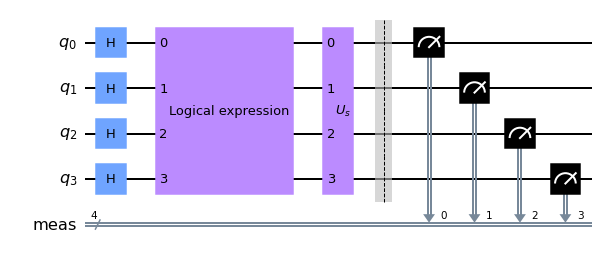

In [46]:
n = num_assets
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.append(oracle_gate, [0,1,2,3])
grover_circuit.append(diffuser(n), [0,1,2,3])
grover_circuit.measure_all()
grover_circuit.draw('mpl')

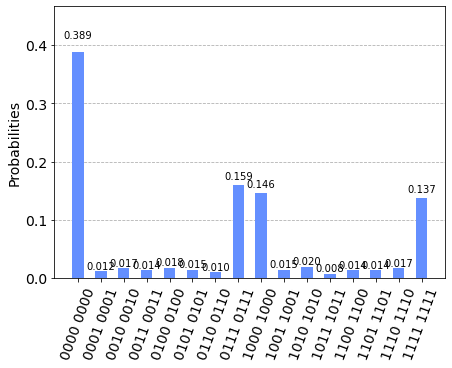

In [48]:
grover_circuit.measure_all()

qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

#### Grover with double iteration

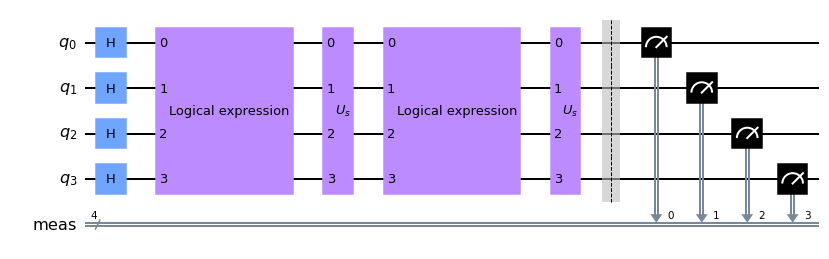

In [50]:
n = num_assets
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.append(oracle_gate, [0,1,2,3])
grover_circuit.append(diffuser(n), [0,1,2,3])
grover_circuit.append(oracle_gate, [0,1,2,3])
grover_circuit.append(diffuser(n), [0,1,2,3])
grover_circuit.measure_all()
grover_circuit.draw('mpl')

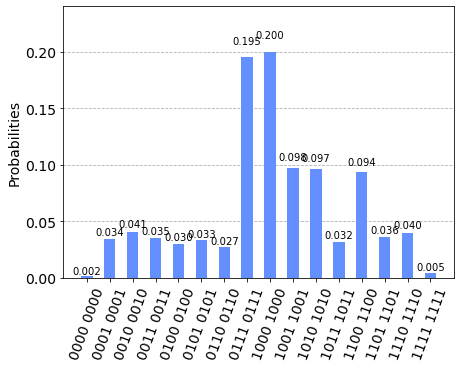

In [51]:
grover_circuit.measure_all()

qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

#### Grover with triple iteration

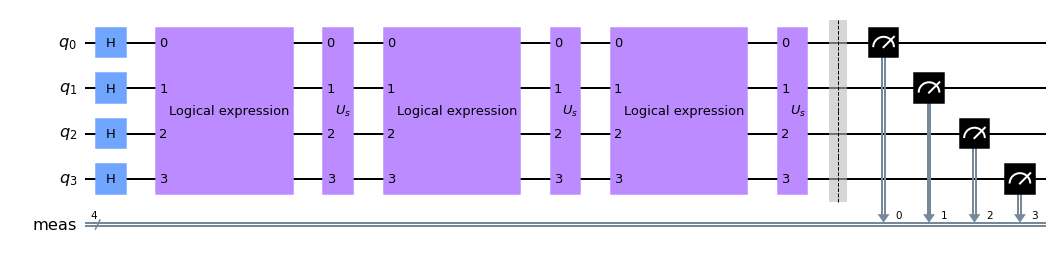

In [53]:
n = num_assets
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.append(oracle_gate, [0,1,2,3])
grover_circuit.append(diffuser(n), [0,1,2,3])
grover_circuit.append(oracle_gate, [0,1,2,3])
grover_circuit.append(diffuser(n), [0,1,2,3])
grover_circuit.append(oracle_gate, [0,1,2,3])
grover_circuit.append(diffuser(n), [0,1,2,3])
grover_circuit.measure_all()
grover_circuit.draw('mpl')

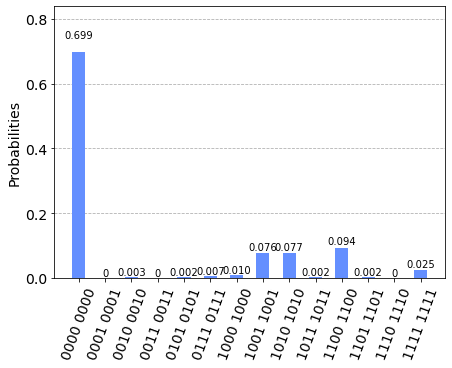

In [54]:
grover_circuit.measure_all()

qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(grover_circuit, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [67]:
%qiskit_version_table